In [1]:
import pandas as pd
import dask
dask.config.set(scheduler="processes")
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy import stats
import glob
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Loading the data

In [35]:
signal = "trade"
stock = "MSFT"
market = "B"
markets=["B","C","DF","II","MW","O","OQ","P"]

files = glob.glob(f"./Data/{signal}\\{stock}.{market}\\*.csv.gz")

print(f"signal : {signal},  #files : {len(files)}, stock: {stock}, market:{market}")

def convert_time(df):
    df["date"] = pd.to_datetime(df["xltime"],unit="d",origin="1899-12-30",utc=True)
    return df
# open_time  = "09:30:00"
# close_time = "16:00:00"
def load_trade_file(file):
    res = pd.read_csv(file,compression="gzip")
    res = convert_time(res)
    res = res[res["trade-stringflag"] == "uncategorized"]
    return res[["trade-price","date"]].drop_duplicates().set_index("date")

def load_bbo_file(file):
    res = pd.read_csv(file,compression="gzip").rename(columns={"bid-price":"bid"})
    res = convert_time(res)
    res = res[res.bid>0]
    #res = res.bid.diff(1).dropna()>0 
    return res[["bid","xltime"]].drop_duplicates().set_index("xltime")

def load_daily_data(date):
    daily_data = {}
    for market in markets:
        try : 
            path = glob.glob(f"./Data/{signal}\\{stock}.{market}\\{date}*.csv.gz")[0]
            daily_data[market] = load_trade_file(path)
        except :
            print(f"missing data : {date} {market}")
    return daily_data

signal : trade,  #files : 251, stock: MSFT, market:B


work on a daily basis

In [36]:
date = '2010-01-04'
daily_data = load_daily_data(date)

# simple data exploration

In [37]:
lengths = {k:len(daily_data[k]) for k in daily_data}
lengths

{'B': 3601,
 'C': 192,
 'DF': 25028,
 'II': 419,
 'MW': 22,
 'O': 41429,
 'OQ': 5571,
 'P': 3750}

In [42]:
N = len(markets)
joined_len_outer = np.zeros((N,N))
joined_len_inner = np.zeros((N,N))
for i,k1 in enumerate(daily_data):
    for j,k2 in enumerate(daily_data):
        s1,s2 = daily_data[k1].copy(),daily_data[k2].copy()
        l_outer = len(generate_delayed_data(s1,s2,0))
        l_inner = len(generate_delayed_data(s1,s2,0,join_type="inner"))
        joined_len_outer[i,j] = l_outer
        joined_len_inner[i,j] = l_inner


In [43]:
fig = make_subplots(rows=1, cols=2,shared_yaxes=True,subplot_titles=["inner","outer"])

fig.add_trace(
    go.Heatmap(z=joined_len_inner,x=markets,y=markets),
    row=1, col=1
)

fig.add_trace(
    go.Heatmap(z=joined_len_outer,x=markets,y=markets),
    row=1, col=2
)

fig.update_layout(height=600, width=800, title_text="Join lenghts")
fig.show()

# Sanity checks
differente opening hours
9h30-16h30

# Signal visu

In [8]:
def generate_delayed_data(s1,s2,delay,join_type="outer"):
    s1 = s1.copy()
    s2 = s2.copy()
    s1.index = s1.index +pd.Timedelta(milliseconds=delay) 
    pair_data = s1.join(s2,how =join_type ,lsuffix="_1",rsuffix="_2").ffill().dropna()    
    return pair_data

# from https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/
def compute_correlation(pair_data):
    s1,s2 = pair_data["trade-price_1"].values, pair_data["trade-price_2"].values
    N = len(s1)
    r, p = stats.pearsonr(s1,s2)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(N-3)
    alpha = 0.05
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r,lo, hi


def visualize_delay(n1,n2,delay,n_samples=1000):
    s1,s2 = daily_data[n1],daily_data[n2]
    pair_data = generate_delayed_data(s1,s2,delay)[:n_samples]
    corr,_,_      = compute_correlation(pair_data)
    
    plt.plot(pair_data["trade-price_1"])
    plt.plot(pair_data["trade-price_2"])
    plt.title(f"delay:{delay}ms, market1:{n1}, market2:{n2}, corr={corr:0.5f}")
    plt.show()

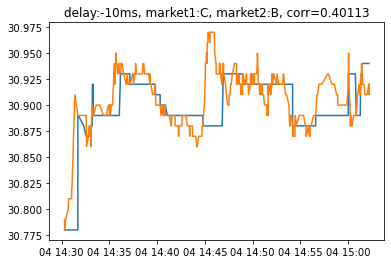

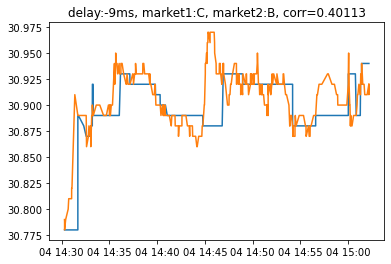

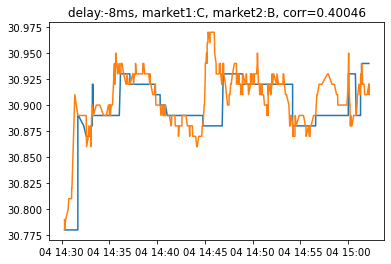

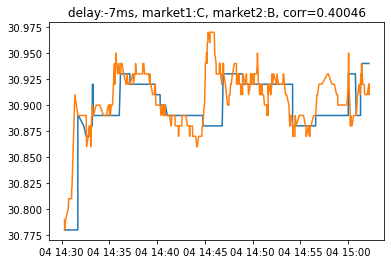

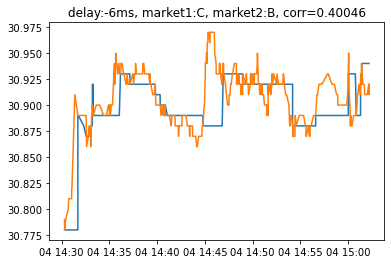

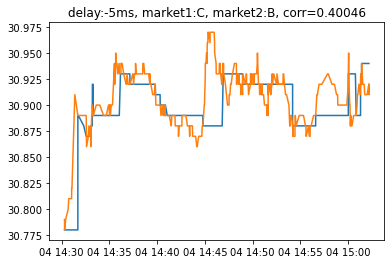

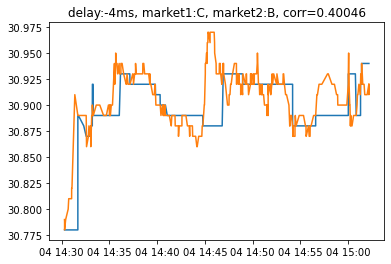

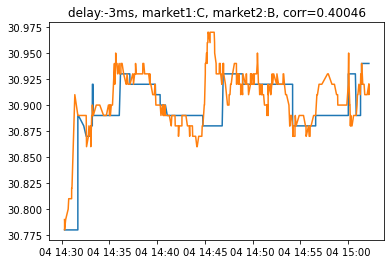

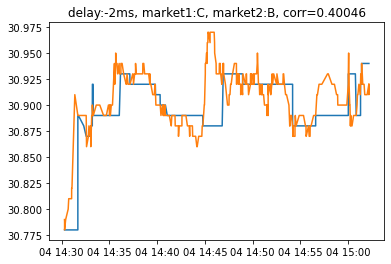

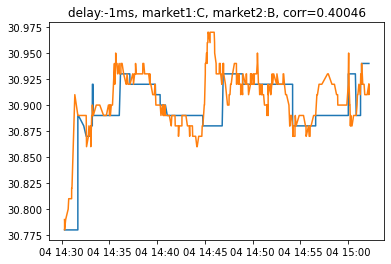

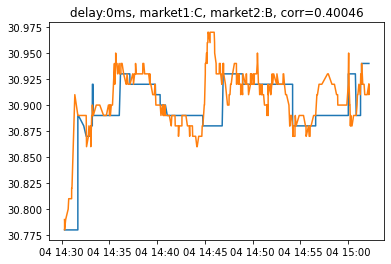

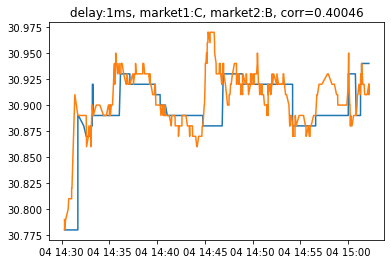

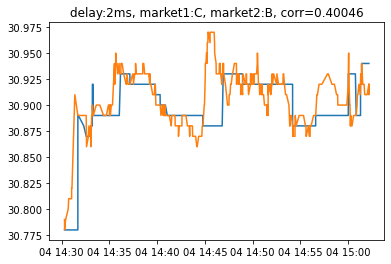

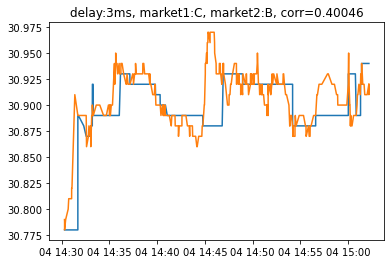

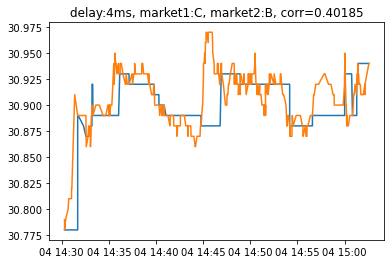

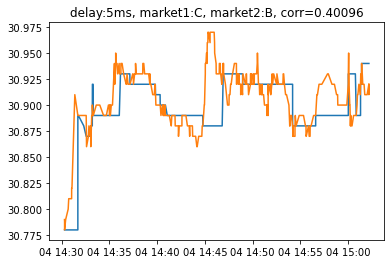

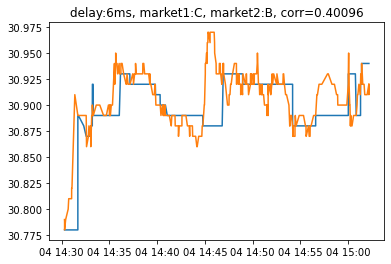

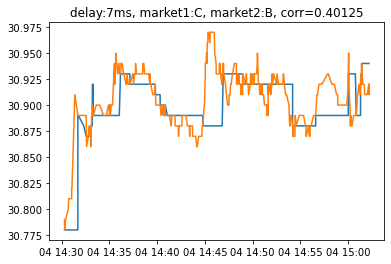

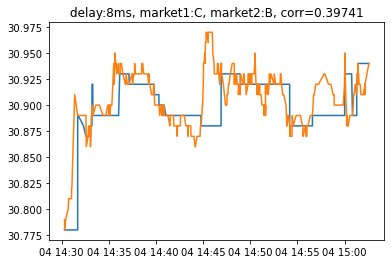

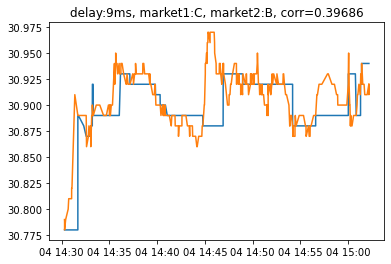

In [29]:
step = 1 #ms
delays = range(-10*step,10*step,step)
for delay in delays:
    visualize_delay(n1="C",n2="B",delay=delay)

# Correlation computation

* optimize range exploration, binary search, save intermediate results

In [114]:
n_step = 20
def compute_delays(n1,n2,center=0,step_size=1000):
    correlations = []
    los=[]
    his=[]
    
    delays = range(center-n_step*step_size,center+n_step*step_size,step_size)
    for delay in delays:
        s1,s2 = daily_data[n1].copy(),daily_data[n2].copy()
        pair_data = generate_delayed_data(s1,s2,delay)
        corr,lo,hi      = compute_correlation(pair_data)
        correlations.append(corr)
        los.append(corr-lo)
        his.append(hi-corr)
    return delays,correlations,los,his

# iterative algorithm

In [172]:


def increasing_function_check(correlations):
    N = len(correlations)
    max_idx = np.argmax(correlations)
    return not (max_idx>0.1*N and max_idx<0.9*N)

def find_best_delay(n1,n2):
    n_iteration = 15
    center      = 0
    step_size   = 1000 #ms
    last_best_delay = None
    for it in range(n_iteration):
        delays,correlations,los,his = compute_delays(n1,n2,center=center,step_size=step_size)
        best_delay = delays[np.argmax(correlations)]
        if (last_best_delay is not None and last_best_delay==best_delay) or not step_size > 1:
            return best_delay,delays,correlations,los,his
        
        
        last_best_delay = best_delay 
        center          = best_delay
        
        print(f"idx:{np.argmax(correlations)}, step_size:{step_size}, center:{center}")
        if increasing_function_check(correlations):
            step_size = int(step_size*1.5)
        else:
            step_size = step_size//2
        
    return best_delay,delays,correlations,los,his
    

# Demo

In [210]:
def find_best_delay_demo(n1,n2):
    n_iteration = 15
    center      = 0
    step_size   = 1000 #ms
    last_best_delay = None
    for it in range(n_iteration):
        delays,correlations,los,his = compute_delays(n1,n2,center=center,step_size=step_size)
        best_delay = delays[np.argmax(correlations)]
        if (last_best_delay is not None and last_best_delay==best_delay) or not step_size > 1:
            break
        
        
        last_best_delay = best_delay 
        center          = best_delay
        
        ######################
        x = list(delays)
        y = correlations
        fig = go.Figure(data=go.Scatter(x=x,y=y,
        error_y=dict(
            type='data',
            symmetric=False,
            array=los,
            arrayminus=his)
        )
        ,layout = go.Layout(autosize=False,width=800,height=500)               
        )
        title = f"Correlation_vs_delay_window_iteration({it})_market({n1}_{n2})"
        fig.update_layout(
        title=title,
        xaxis_title="delay",
        yaxis_title="correlation"
        )
        fig.write_html(f"./Figures/{title}.html",full_html=False, include_plotlyjs=False)
        fig.show()
        
        print(f"idx:{np.argmax(correlations)}, step_size:{step_size}, center:{center}")
        if increasing_function_check(correlations):
            step_size = int(step_size*1.5)
        else:
            step_size = step_size//2
        


In [211]:
find_best_delay_demo("OQ","MW")

idx:38, step_size:1000, center:18000


idx:37, step_size:1500, center:43500


idx:39, step_size:2250, center:86250


idx:38, step_size:3375, center:147000


idx:39, step_size:5062, center:243178


idx:39, step_size:7593, center:387445


idx:39, step_size:11389, center:603836


idx:33, step_size:17083, center:825915


In [212]:
find_best_delay_demo("B","II")

idx:21, step_size:1000, center:1000


# Visu

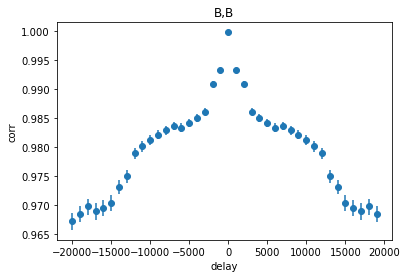

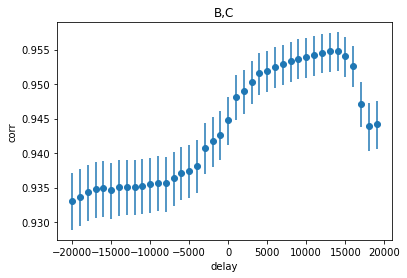

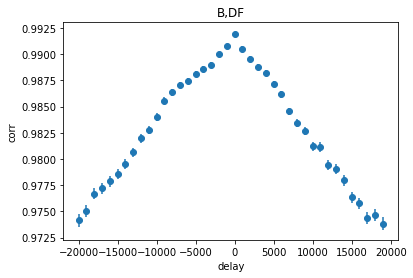

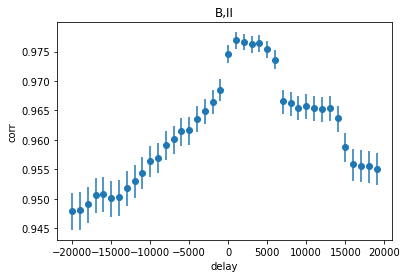

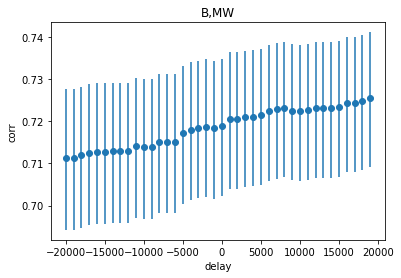

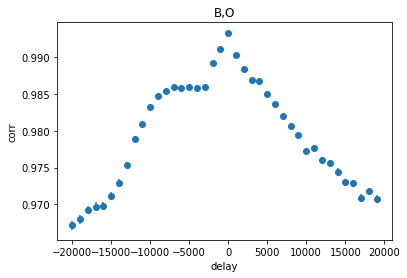

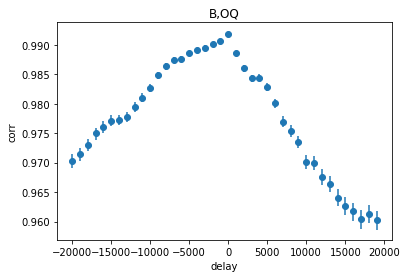

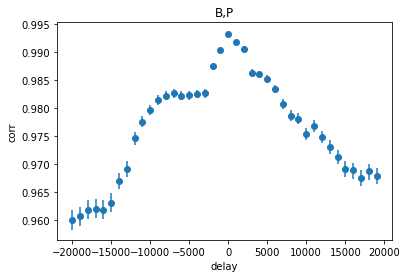

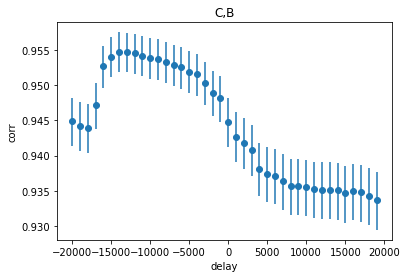

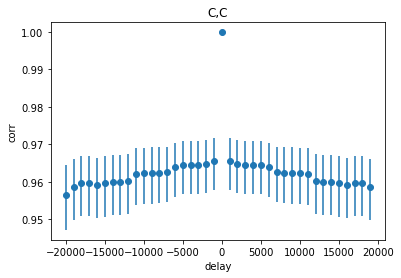

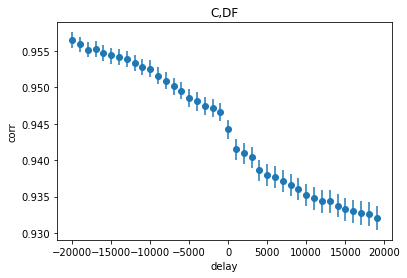

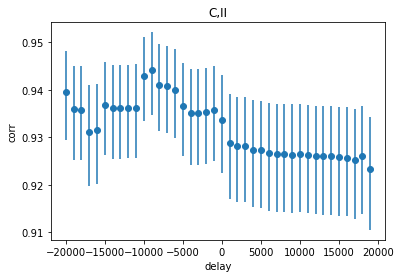

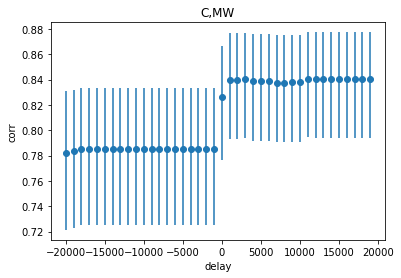

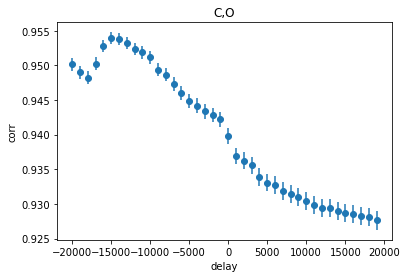

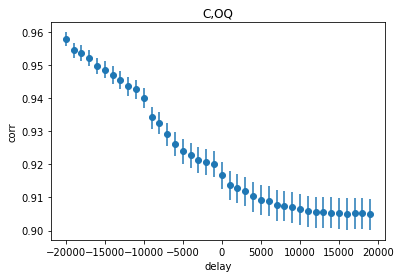

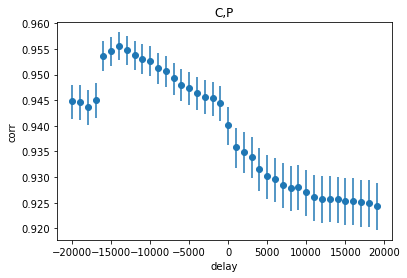

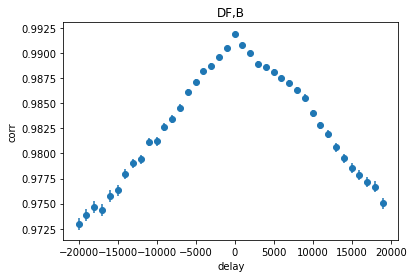

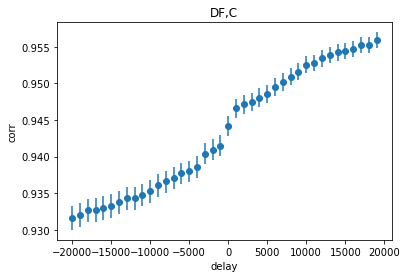

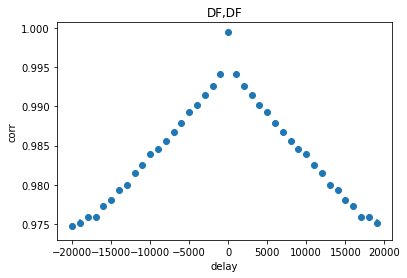

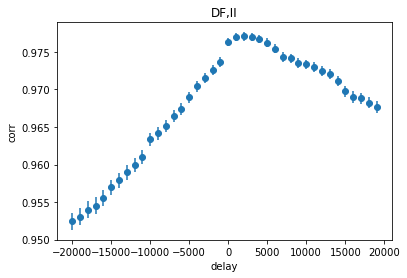

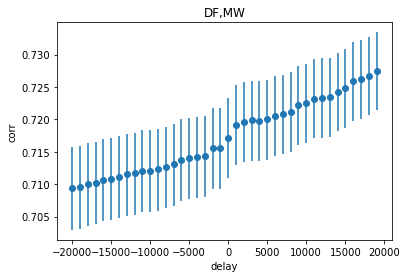

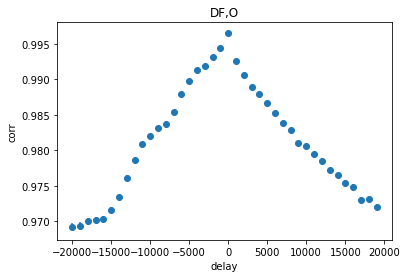

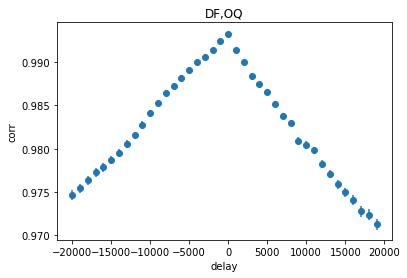

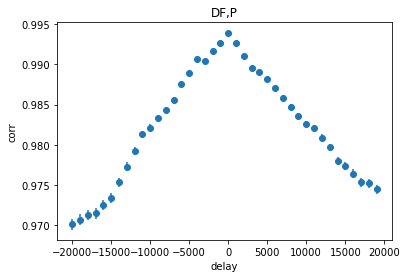

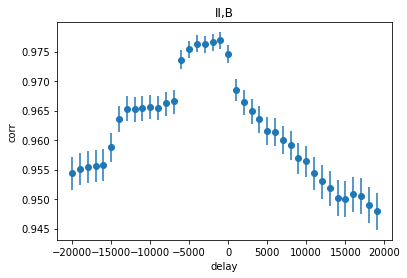

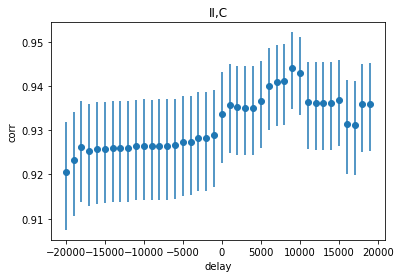

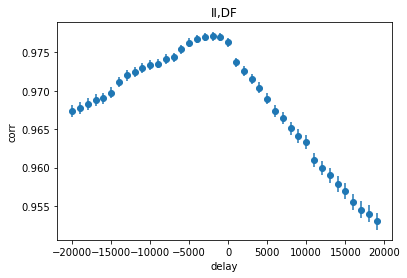

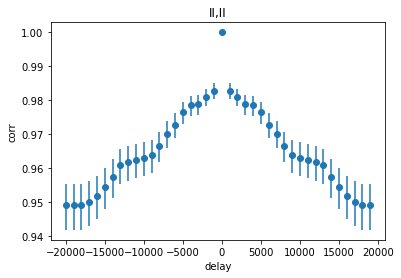

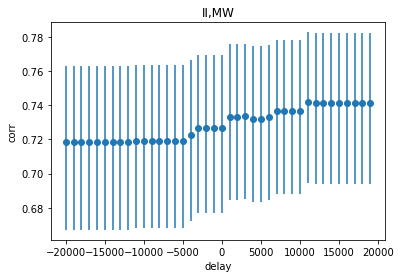

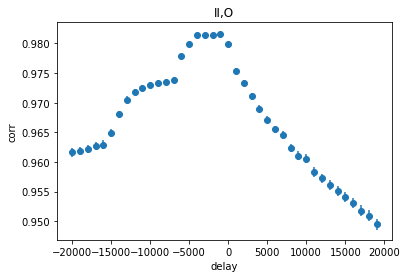

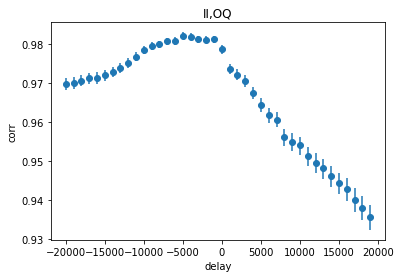

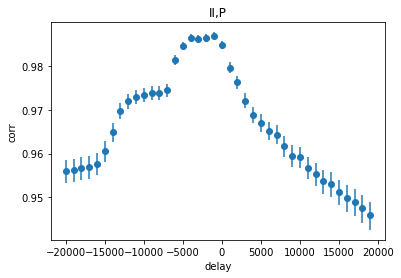

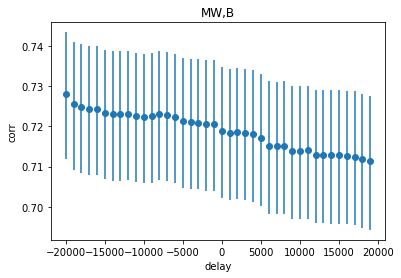

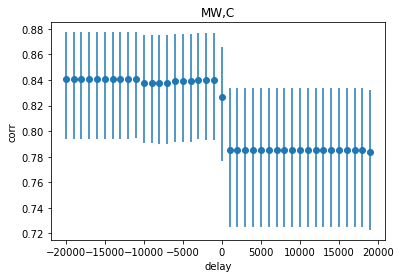

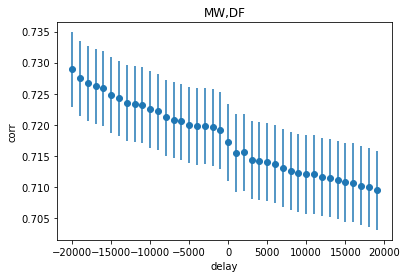

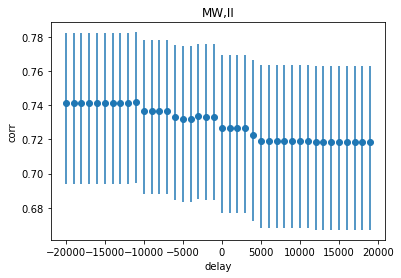

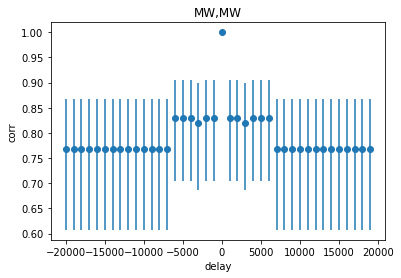

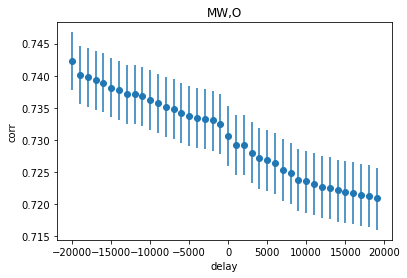

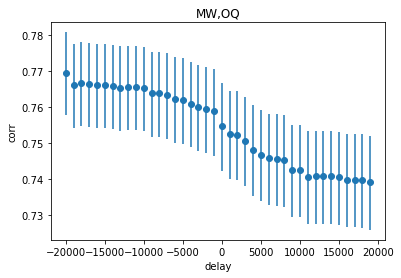

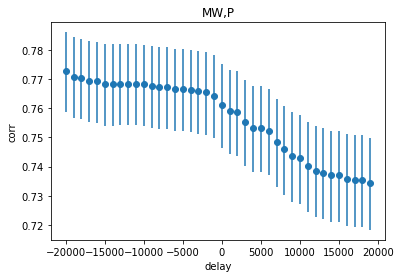

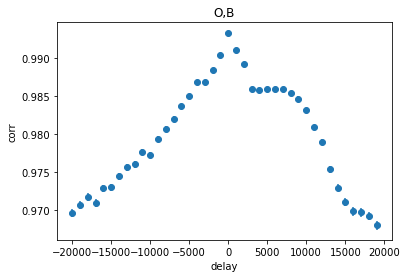

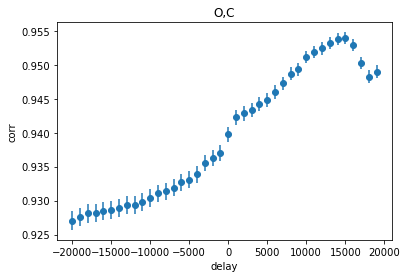

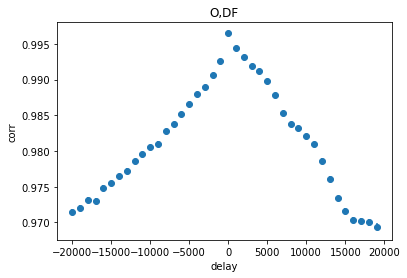

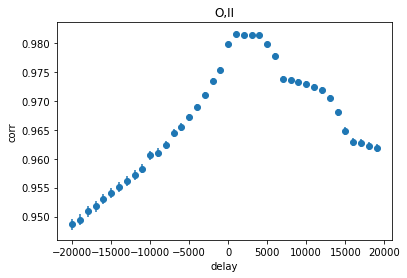

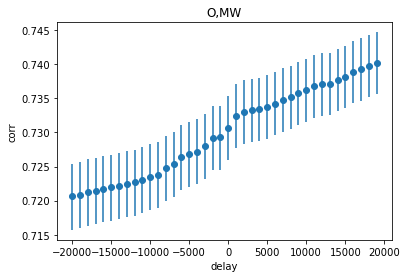

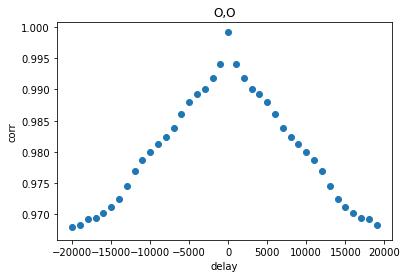

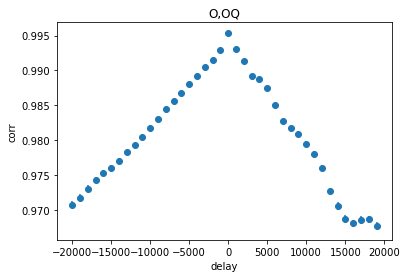

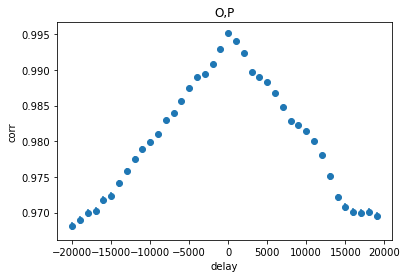

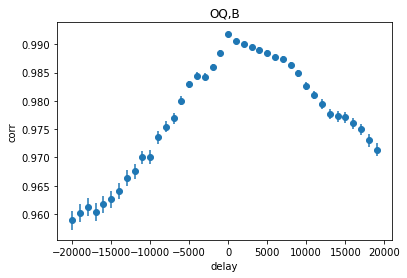

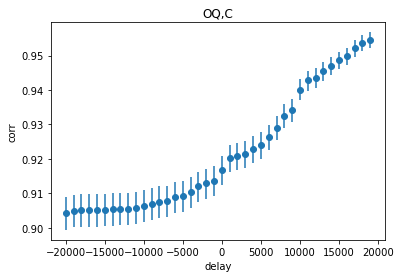

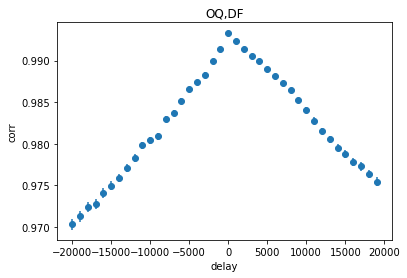

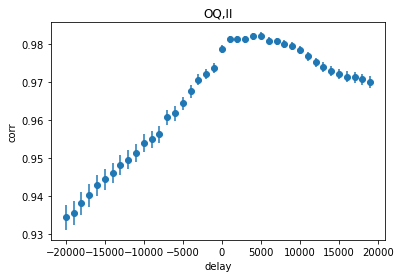

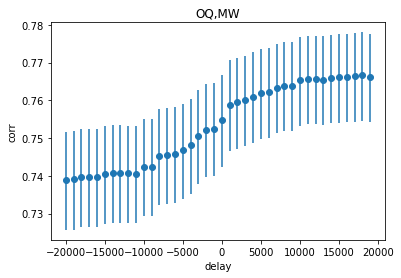

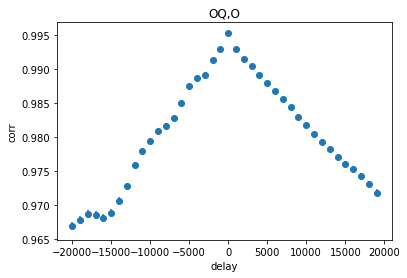

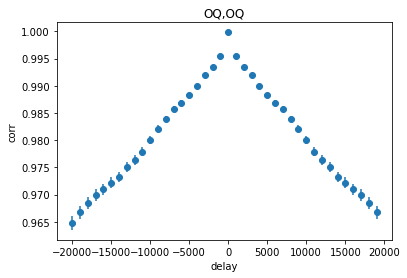

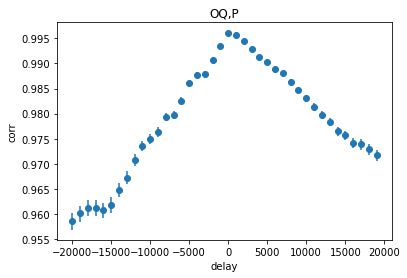

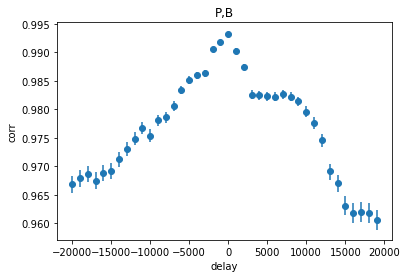

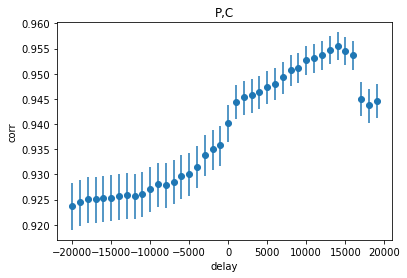

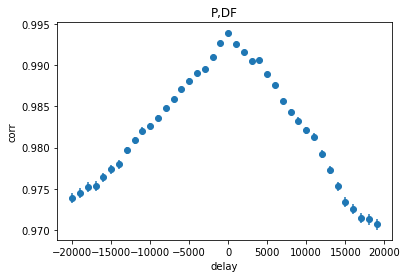

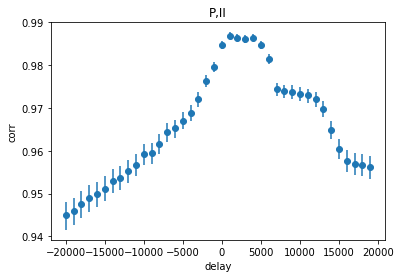

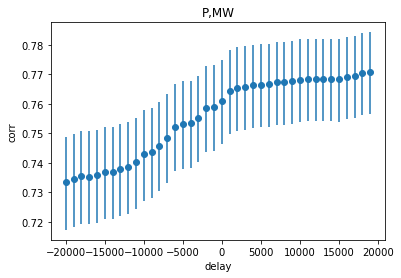

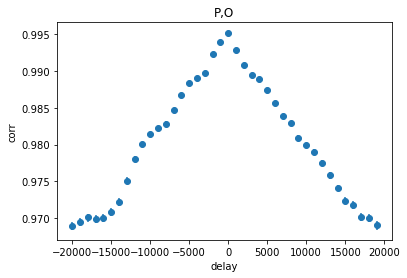

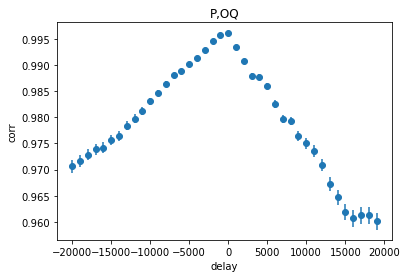

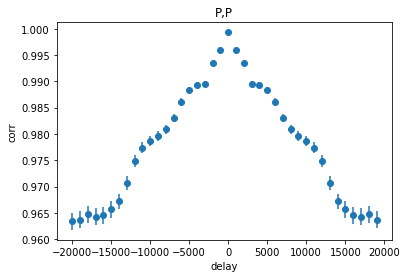

In [154]:
for i,k1 in enumerate(daily_data):
    for j,k2 in enumerate(daily_data):
        delays,correlations,los,his = compute_delays(n1=k1,n2=k2,center=0,step_size=1000)
        x = list(delays)
        y = correlations
        errors = [los,his]
        plt.errorbar(x, y, yerr=errors, fmt='o')
        plt.title(f"{k1},{k2}")
        plt.xlabel("delay")
        plt.ylabel("corr")
        plt.show()

None 0
idx:20, step_size:10000, center:0
0 0


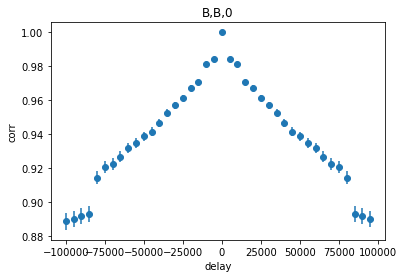

None 10000
idx:21, step_size:10000, center:10000
10000 15000
idx:21, step_size:5000, center:15000
15000 12500
idx:19, step_size:2500, center:12500
12500 13750
idx:21, step_size:1250, center:13750
13750 14375
idx:21, step_size:625, center:14375
14375 14375


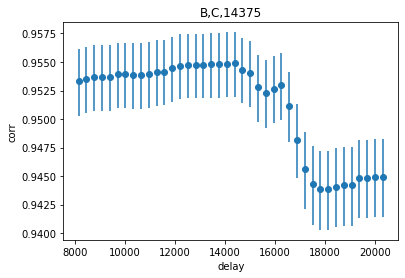

None 0
idx:20, step_size:10000, center:0
0 0


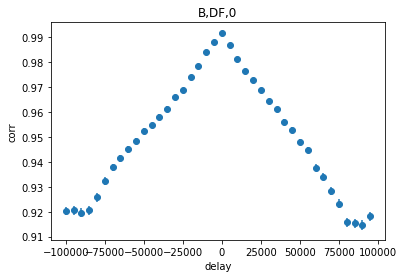

None 0
idx:20, step_size:10000, center:0
0 5000
idx:21, step_size:5000, center:5000
5000 2500
idx:19, step_size:2500, center:2500
2500 1250
idx:19, step_size:1250, center:1250
1250 1250


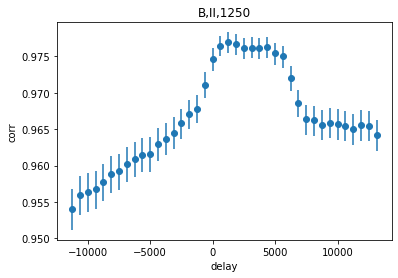

None 190000
idx:39, step_size:10000, center:190000
190000 475000
idx:39, step_size:15000, center:475000
475000 812500
idx:35, step_size:22500, center:812500
812500 823750
idx:21, step_size:11250, center:823750
823750 829375
idx:21, step_size:5625, center:829375
829375 829375


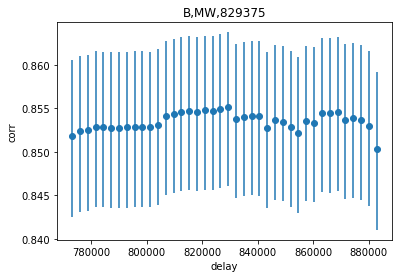

None 0
idx:20, step_size:10000, center:0
0 0


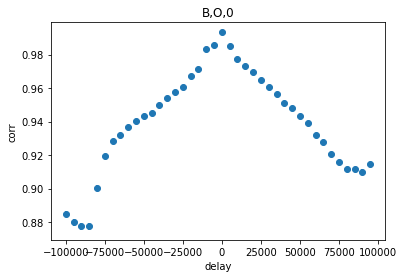

None 0
idx:20, step_size:10000, center:0
0 0


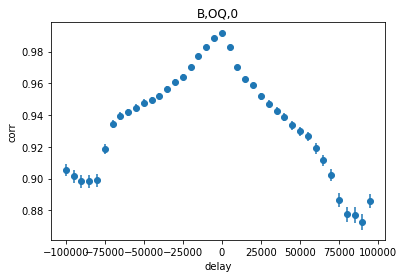

None 0
idx:20, step_size:10000, center:0
0 0


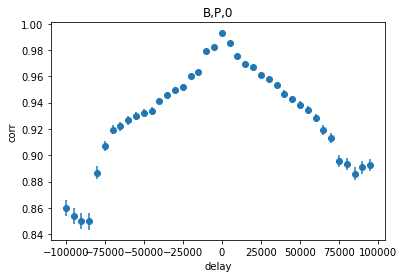

None -10000
idx:19, step_size:10000, center:-10000
-10000 -15000
idx:19, step_size:5000, center:-15000
-15000 -12500
idx:21, step_size:2500, center:-12500
-12500 -13750
idx:19, step_size:1250, center:-13750
-13750 -14375
idx:19, step_size:625, center:-14375
-14375 -14375


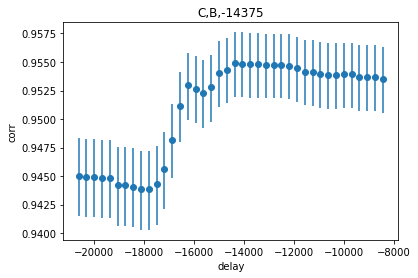

None 0
idx:20, step_size:10000, center:0
0 0


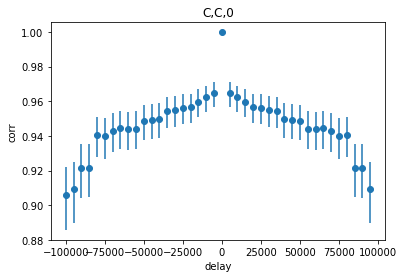

None -30000
idx:17, step_size:10000, center:-30000
-30000 -30000


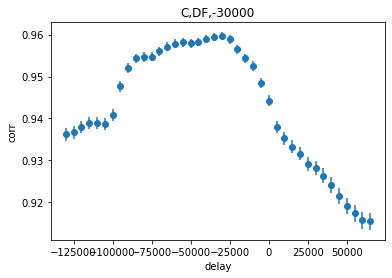

None -30000
idx:17, step_size:10000, center:-30000
-30000 -35000
idx:19, step_size:5000, center:-35000
-35000 -32500
idx:21, step_size:2500, center:-32500
-32500 -32500


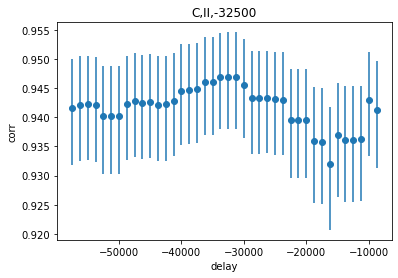

None 170000
idx:37, step_size:10000, center:170000
170000 380000
idx:34, step_size:15000, center:380000
380000 372500
idx:19, step_size:7500, center:372500
372500 368750
idx:19, step_size:3750, center:368750
368750 366875
idx:19, step_size:1875, center:366875


KeyboardInterrupt: 

In [159]:
for i,k1 in enumerate(daily_data):
    for j,k2 in enumerate(daily_data):
        best_delay,delays,correlations,los,his = find_best_delay(n1=k1,n2=k2)
        x = list(delays)
        y = correlations
        errors = [los,his]
        plt.errorbar(x, y, yerr=errors, fmt='o')
        plt.title(f"{k1},{k2},{best_delay}")
        plt.xlabel("delay")
        plt.ylabel("corr")
        plt.show()




# Checks

* sort by delay and vaidates with geo distance
* moore's law